In [123]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation

import gym
from gym import wrappers

%matplotlib inline

In [129]:
ENV = 'CartPole-v0'  # 使用する課題名
NUM_DIZITIZED = 6  # 各状態の離散値への分割数
GAMMA = 0.99  # 時間割引率
ETA = 0.5  # 学習係数
MAX_STEPS = 200  # 1試行のstep数
NUM_EPISODES = 1000  # 最大試行回数

In [130]:
class Agent:
    '''CartPoleのエージェントクラスです、棒付き台車そのものになります'''
    def __init__(self, num_states, num_actions):
        self.brain = Brain(num_states, num_actions)  # エージェントが行動を決定するための頭脳を生成

    def update_Q_function(self, observation, action, reward, observation_next):
        '''Q関数の更新'''
        self.brain.update_Q_table(observation, action, reward, observation_next)

    def get_action(self, observation, step):
        '''行動の決定'''
        return self.brain.decide_action(observation, step)

In [131]:
class Brain:
    '''エージェントが持つ脳となるクラスです、Q学習を実行します'''

    def __init__(self, num_states, num_actions):
        self.num_actions = num_actions  # CartPoleの行動（右に左に押す）の2を取得

        # Qテーブルを作成。行数は状態を分割数^（4変数）にデジタル変換した値、列数は行動数を示す
        self.q_table = np.random.uniform(low=0, high=1, size=(NUM_DIZITIZED**num_states, num_actions))

    def bins(self, clip_min, clip_max, num):
        '''観測した状態（連続値）を離散値にデジタル変換する閾値を求める'''
        return np.linspace(clip_min, clip_max, num + 1)[1:-1]

    def digitize_state(self, observation):
        '''観測したobservation状態を、離散値に変換する'''
        
        cart_pos, cart_v, pole_angle, pole_v = observation
        digitized = [
            np.digitize(cart_pos, bins=self.bins(-2.4, 2.4, NUM_DIZITIZED)),
            np.digitize(cart_v, bins=self.bins(-3.0, 3.0, NUM_DIZITIZED)),
            np.digitize(pole_angle, bins=self.bins(-0.5, 0.5, NUM_DIZITIZED)),
            np.digitize(pole_v, bins=self.bins(-2.0, 2.0, NUM_DIZITIZED))
        ]
        return sum([x * (NUM_DIZITIZED**i) for i, x in enumerate(digitized)])

    def update_Q_table(self, observation, action, reward, observation_next):
        '''QテーブルをQ学習により更新'''
        state = self.digitize_state(observation)  # 状態を離散化
        state_next = self.digitize_state(observation_next)  # 次の状態を離散化
        # 次の状態において最も価値が高い方法を取得する
        Max_Q_next = max(self.q_table[state_next][:])
        self.q_table[state, action] = self.q_table[state, action] + \
            ETA * (reward + GAMMA * Max_Q_next - self.q_table[state, action])

    def decide_action(self, observation, episode):
        '''ε-greedy法で徐々に最適行動のみを採用する'''
        state = self.digitize_state(observation)
        epsilon = 0.5 * (1 / (episode + 1))

        if epsilon <= np.random.uniform(0, 1):
            action = np.argmax(self.q_table[state][:])
        else:
            action = np.random.choice(self.num_actions)  # 0,1の行動をランダムに返す
        return action
    

In [132]:
class Environment:
    '''CartPoleを実行する環境のクラスです'''

    def __init__(self):
        self.env = gym.make(ENV, render_mode="rgb_array")  # 実行する課題を設定
        num_states = self.env.observation_space.shape[0]  # 課題の状態の数4を取得
        num_actions = self.env.action_space.n  # CartPoleの行動（右に左に押す）の2を取得
        self.agent = Agent(num_states, num_actions)  # 環境内で行動するAgentを生成
        self.frames = []

    def run(self):
        '''実行'''
        complete_episodes = 0  # 195step以上連続で立ち続けた試行数
        is_episode_final = False  # 最終試行フラグ

        for episode in range(NUM_EPISODES):  # 試行数分繰り返す
            observation = self.env.reset()[0]  # 環境の初期化

            for step in range(MAX_STEPS):  # 1エピソードのループ

                if is_episode_final is True:  # 最終試行ではframesに各時刻の画像を追加していく
                    self.frames.append(self.env.render())

                # 行動を求める
                action = self.agent.get_action(observation, episode)

                # 行動a_tの実行により、s_{t+1}, r_{t+1}を求める
                observation_next, _, done, _, _ = self.env.step(action)  # rewardとinfoは使わないので_にする

                # 報酬を与える
                if done:  # ステップ数が200経過するか、一定角度以上傾くとdoneはtrueになる
                    if step < 195:
                        reward = -1  # 途中でこけたら罰則として報酬-1を与える
                        complete_episodes = 0  # 195step以上連続で立ち続けた試行数をリセット
                    else:
                        reward = 1  # 立ったまま終了時は報酬1を与える
                        complete_episodes += 1  # 連続記録を更新
                else:
                    reward = 0  # 途中の報酬は0

                # step+1の状態observation_nextを用いて,Q関数を更新する
                self.agent.update_Q_function(observation, action, reward, observation_next)

                # 観測の更新
                observation = observation_next

                # 終了時の処理
                if done:
                    print('{0} Episode: Finished after {1} time steps'.format(
                        episode, step + 1))
                    break

            if is_episode_final is True:  # 最終試行では動画を保存と描画
                break

            if complete_episodes >= 10:  # 10連続成功なら
                print('10回連続成功')
                is_episode_final = True  # 次の試行を描画を行う最終試行とする
                
        self.env.close()


In [133]:
cartpole_env = Environment()
cartpole_env.run()

0 Episode: Finished after 44 time steps
1 Episode: Finished after 30 time steps
2 Episode: Finished after 15 time steps
3 Episode: Finished after 24 time steps
4 Episode: Finished after 92 time steps
5 Episode: Finished after 19 time steps
6 Episode: Finished after 42 time steps
7 Episode: Finished after 14 time steps
8 Episode: Finished after 38 time steps
9 Episode: Finished after 70 time steps
10 Episode: Finished after 63 time steps
11 Episode: Finished after 108 time steps
12 Episode: Finished after 116 time steps
13 Episode: Finished after 79 time steps
14 Episode: Finished after 28 time steps
15 Episode: Finished after 38 time steps
16 Episode: Finished after 54 time steps
17 Episode: Finished after 30 time steps
18 Episode: Finished after 63 time steps
19 Episode: Finished after 29 time steps
20 Episode: Finished after 13 time steps
21 Episode: Finished after 72 time steps
22 Episode: Finished after 31 time steps
23 Episode: Finished after 58 time steps
24 Episode: Finished aft

In [134]:
def save_gif(frames):
    fig = plt.figure(figsize=(frames[0].shape[1]/72.0, frames[0].shape[0]/72.0), dpi=72)
    ax = fig.add_subplot()
    ax.axis('off')
    output_frames = [[plt.imshow(f)] for f in frames]
    anim = animation.ArtistAnimation(fig, output_frames, interval=50, repeat=False)
    anim.save("animation.gif", writer="pillow")

if not cartpole_env.frames:
    print("学習がおわりませんでした")
else:
    print("gifを保存します")
    save_gif(cartpole_env.frames)

学習がおわりませんでした


In [ ]:
# APIが変わっているので以下確認
# https://www.gymlibrary.dev/
# frames = []
# env = gym.make(ENV, render_mode="rgb_array")
# observation = env.reset()  # 最初に環境のresetが必要

# def bins(clip_min, clip_max, num):
#     return np.linspace(clip_min, clip_max, num + 1)[1:-1]

# def digitize_state(observation):
#     cart_pos, cart_v, pole_angle, pole_v = observation
#     digitized = [
#         np.digitize(cart_pos, bins=bins(-2.4, 2.4, NUM_DIZITIZED)),
#         np.digitize(cart_v, bins=bins(-3.0, 3.0, NUM_DIZITIZED)),
#         np.digitize(pole_angle, bins=bins(-0.5, 0.5, NUM_DIZITIZED)),
#         np.digitize(pole_v, bins=bins(-2.0, 2.0, NUM_DIZITIZED))]
#     return sum([x * (NUM_DIZITIZED**i) for i, x in enumerate(digitized)])

# for step in range(0, 100):
#     frames.append(env.render())  # framesに各時刻の画像を追加していく
#     action = np.random.choice(2)  # 0(カートを左に押す), 1(カートを右に押す)をランダムに返す
#     env.step(action)
#     observation, reward, terminated, truncated, info = env.step(action)  # actionを実行する

# env.close()

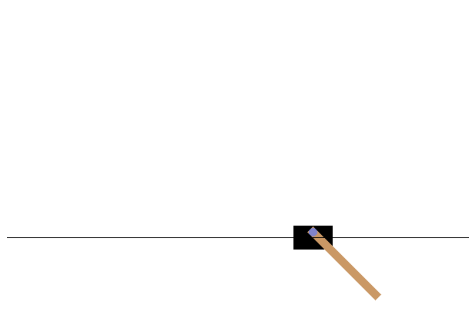